## Adding noise via SDE's
We can now demonstrate how a few of the input features will be changed via the noising procedures. We perturb the data according to the standard deviation of the distribution defined by the SDE. If the std is large enough, we are able to populate less dense regions of data / less populated regions of the PDF. Play around with varying size coefficients used in the SDE beneath to see how they affect the std of the SDE and subsequently its ability to populate low density regions.

### Variation Preserving SDE
Data will be perturbed according to the SDE defined in utils.py. Note that even when t==0, though the 'mean' of the data will return the same data as before (multiplied by unity), we still add noise to it, thus smearing the input data a little. This SDE progressively smears and moves the mean of the data.

Tue Jan  2 14:59:37 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:07.0 Off |                    0 |
| N/A   75C    P0    69W /  70W |  11697MiB / 15360MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

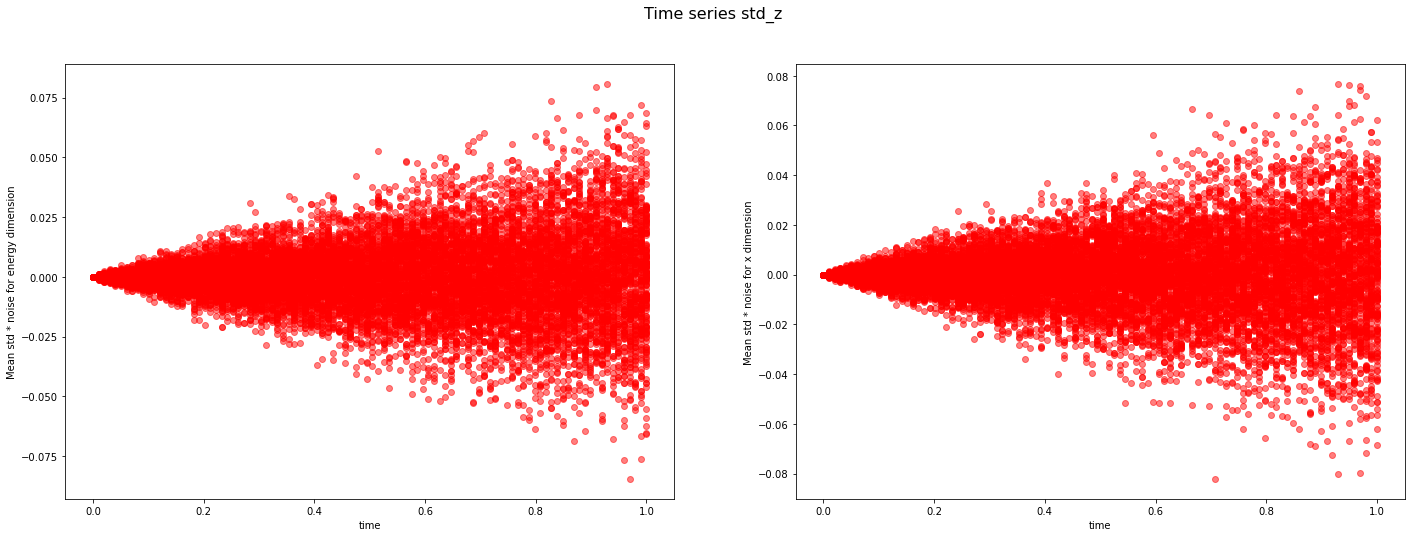

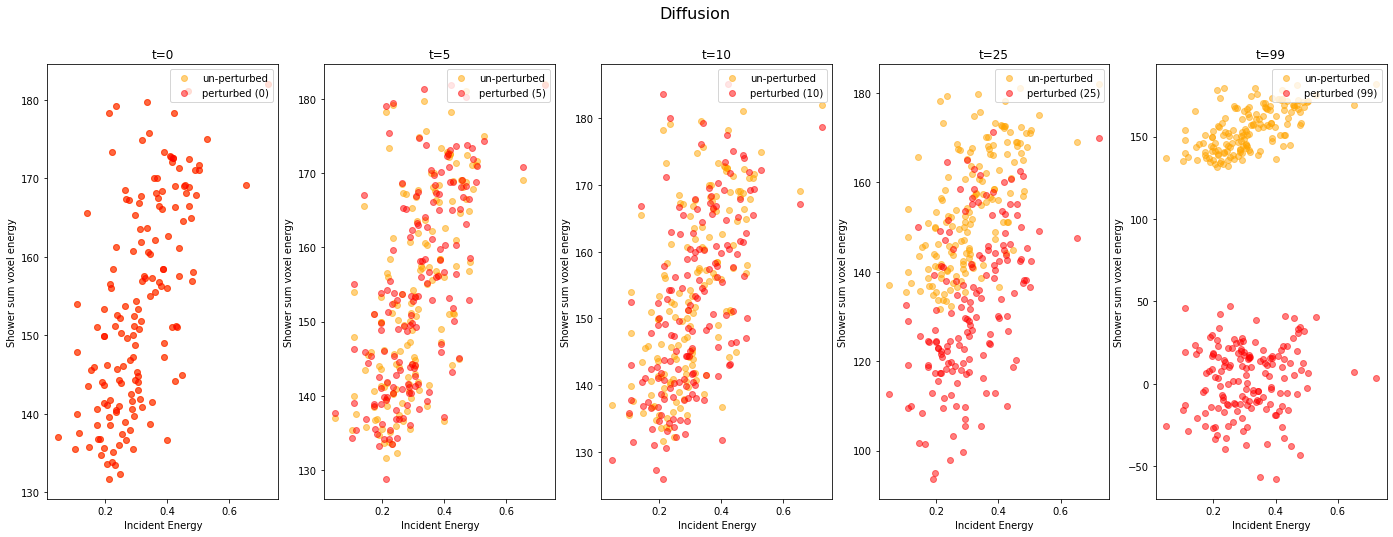

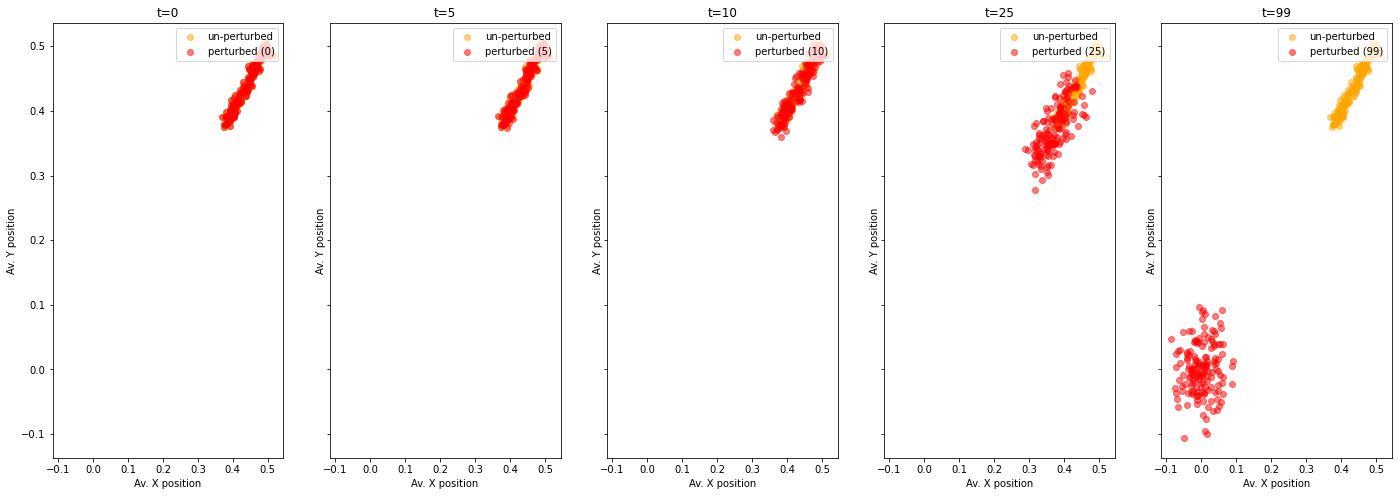

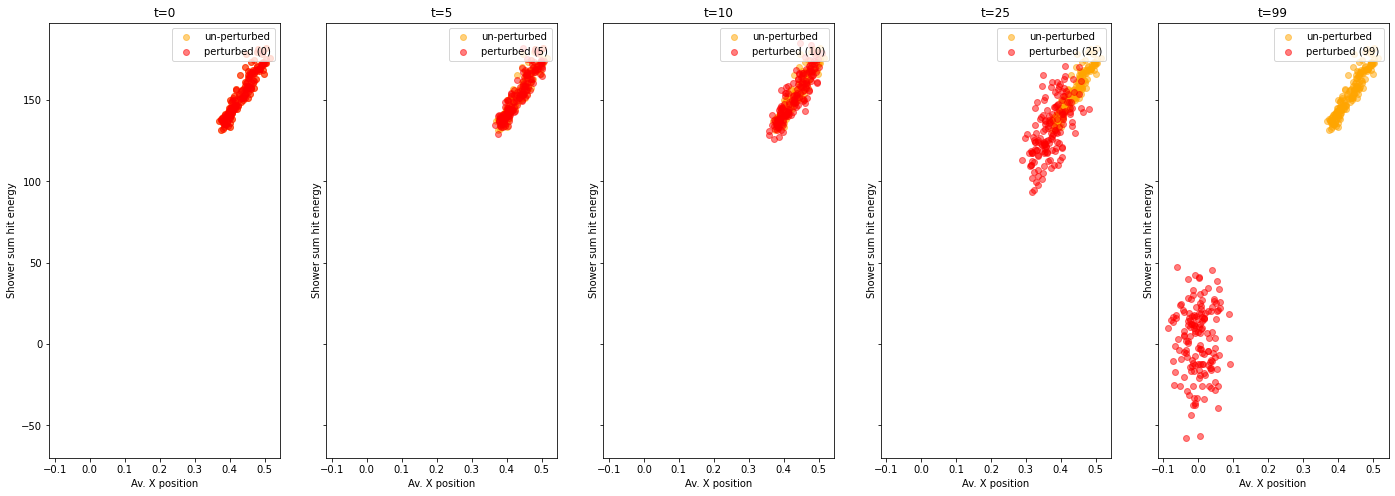

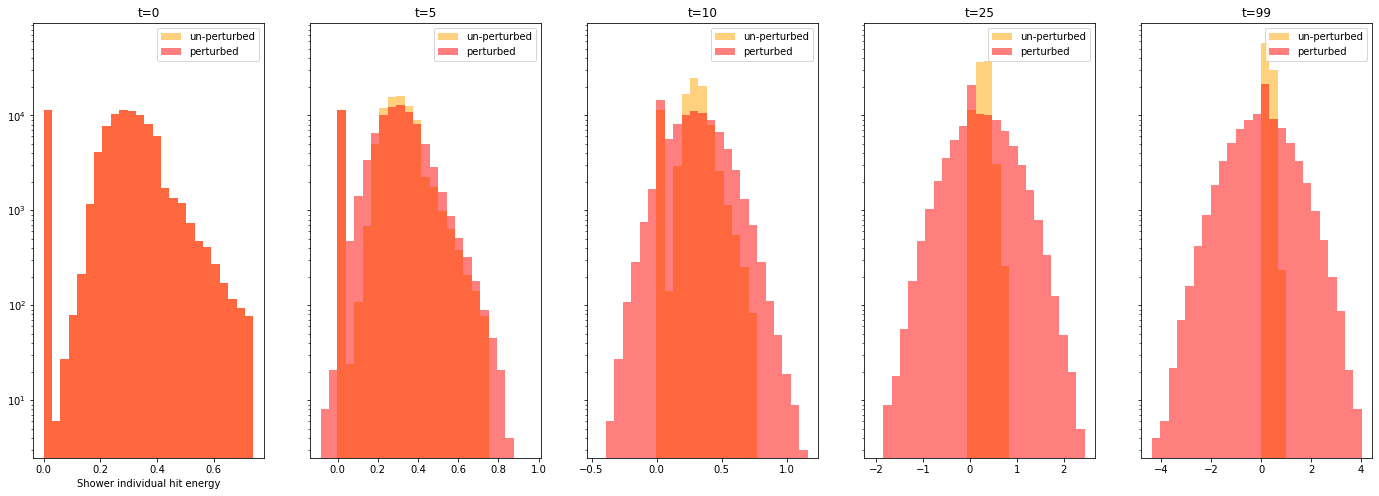

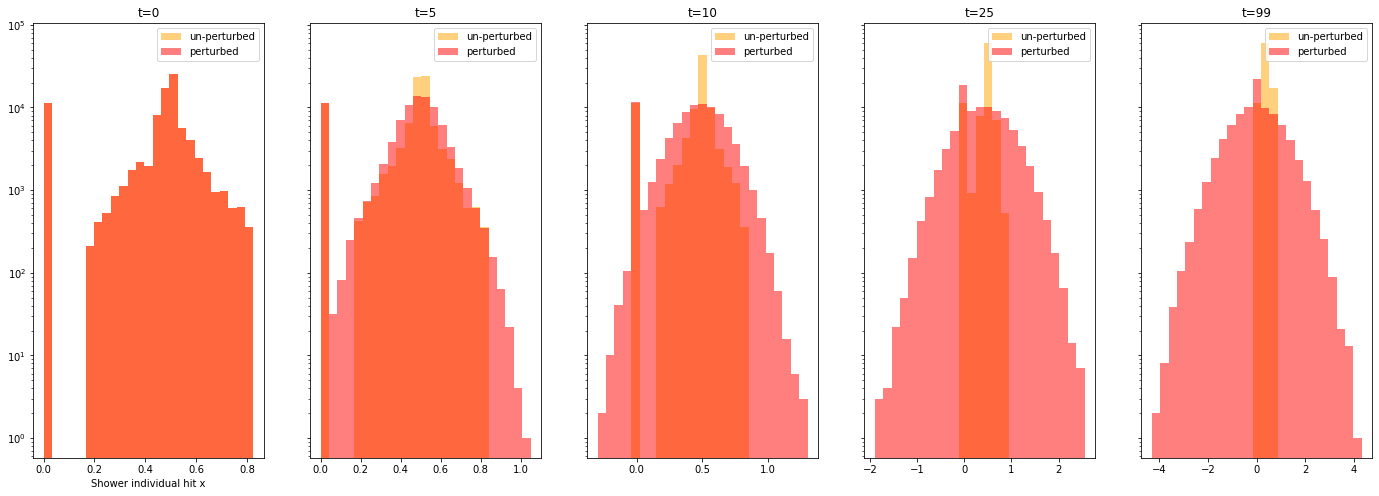

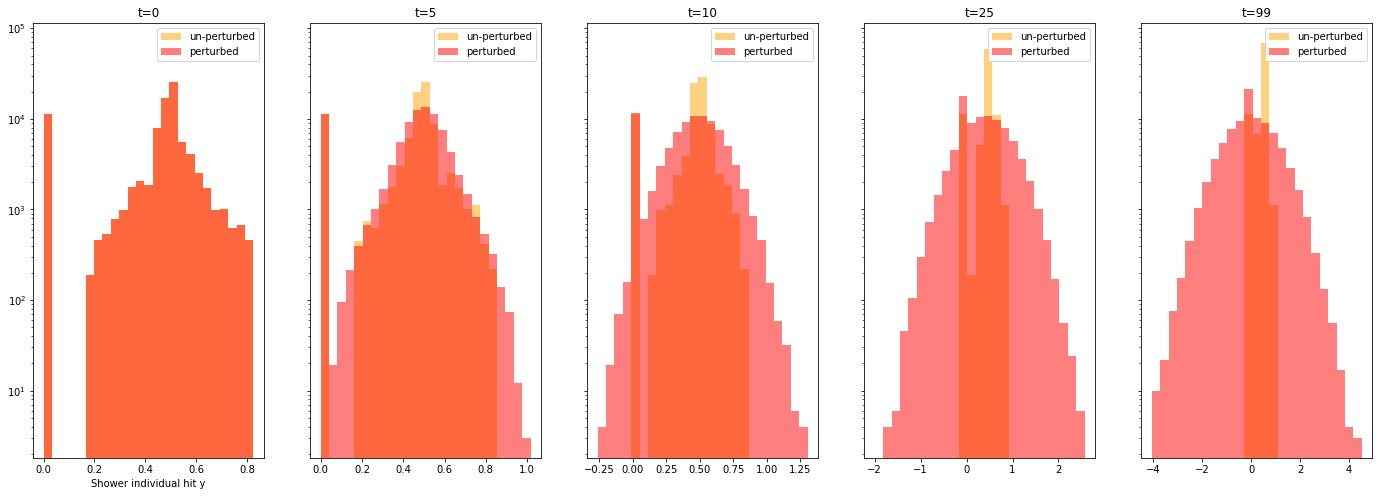

In [4]:
import time, functools, torch, os,sys, random, fnmatch, psutil
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import RAdam
from torch.utils.data import DataLoader
sys.path.insert(1, '../')
import util.sdes as sdes
import util.data_utils as utils
import util.display

# GPU device info
device = 'cuda' if torch.cuda.is_available() else 'cpu'
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:516"
os.system('nvidia-smi')

# Set padding value used
padding_value = 0.0

dataset = "dataset_2_padded_nentry"
preproc_dataset_name = 'ds2_diff_transforms'
dataset_store_path = os.path.join("/eos/user/j/jthomasw/tdsm_encoder/datasets/", preproc_dataset_name)
transform = None
transform_y = None
mask = True
jupyternotebook = True
workingdir = "./"

### SDE PARAMETERS ###
SDE = 'VP'
if SDE == 'VP':
    beta_max = 1.0
    beta_min = 0.01
if SDE == 'VE':
    sigma_max = 20.0
    sigma_min = 0.1

# Instantiate stochastic differential equation
if SDE == 'VP':
    sde = sdes.VPSDE(beta_max=beta_max,beta_min=beta_min, device=device)
if SDE == 'VE':
    sde = sdes.VESDE(sigma_max=sigma_max,sigma_min=sigma_min,device=device)

marginal_prob_std_fn = functools.partial(sde.marginal_prob)

print('torch version: ', torch.__version__)
print('Running on device: ', device)
if torch.cuda.is_available():
    print('Cuda used to build pyTorch: ',torch.version.cuda)
    print('Current device: ', torch.cuda.current_device())
    print('Cuda arch list: ', torch.cuda.get_arch_list())
print('Working directory: ', workingdir)

# Input files
files_list_ = []
for filename in os.listdir(dataset_store_path):
    if fnmatch.fnmatch(filename, dataset + '*424To564.pt'):
        files_list_.append(os.path.join(dataset_store_path, filename))
print(files_list_)


if SDE == 'VP':
    output_dir = 'example_'+SDE+'_SDE_'+str(beta_min)+'_'+str(beta_max)
if SDE == 'VE':
    output_dir = 'example_'+SDE+'_SDE_'+str(sigma_min)+'_'+str(sigma_max)
    
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print(f'output_dir: {output_dir}')

all_incident_e = []

original_hite = []
p0_hite = []
p1_hite = []
p2_hite = []
p3_hite = []
p4_hite = []

original_hitx = []
p0_hitx = []
p1_hitx = []
p2_hitx = []
p3_hitx = []
p4_hitx = []

original_hity = []
p0_hity = []
p1_hity = []
p2_hity = []
p3_hity = []
p4_hity = []

original_sum_hit_energy = []
p0_sum_hit_energy = []
p1_sum_hit_energy = []
p2_sum_hit_energy = []
p3_sum_hit_energy = []
p4_sum_hit_energy = []

original_av_x = []
p0_av_x = []
p1_av_x = []
p2_av_x = []
p3_av_x = []
p4_av_x = []

original_av_y = []
p0_av_y = []
p1_av_y = []
p2_av_y = []
p3_av_y = []
p4_av_y = []

mean_valid_e_std_z_ = []
mean_valid_x_std_z_ = []
mean_valid_y_std_z_ = []
batch_time_steps_ = []
time_steps = np.linspace(0., 1., 100)

steps_to_draw = [0, 5, 10, 25, 99]
    
for filename in files_list_:
    print(filename)
    custom_data = utils.cloud_dataset(filename, device=device)
    train_size = int(0.8 * len(custom_data.data))
    test_size = len(custom_data.data) - train_size
    print(f'train_size: {train_size}, test_size: {test_size}')
    if train_size == 0:
        continue
    train_dataset, test_dataset = torch.utils.data.random_split(custom_data, [train_size, test_size])
    shower_loader_train = DataLoader(train_dataset, batch_size=128, shuffle=True)
    
    print(f'Loading {len(shower_loader_train)} batches')
    
    for i, (shower_data,incident_energies) in enumerate(shower_loader_train,0):
        if i % 20 == 0:
            print(f'Batch: {i}')
        
        # copy tensors to numpy arrays for plotting purposes
        original_data = shower_data.cpu().numpy().copy()
        incident_energies = incident_energies.cpu().numpy().copy()
        
        # Generate padding mask for padded entries
        input_mask = (shower_data[:,:,0] != padding_value).unsqueeze(-1)
        #mask = mask.cpu().numpy().copy()
        diffusion_step_=0
        for time_step in time_steps:
            
            if type(shower_data).__module__ == np.__name__:
                shower_data = torch.from_numpy(shower_data).to(device)
            
            shower_data = shower_data*input_mask
                
            batch_time_step = torch.ones(incident_energies.shape[0], device=device) * time_step

            # Noise input
            z = torch.normal(0,1,size=shower_data.shape, device=device)
            z = z.to(device)
            
            # Multiplied by mask so we don't perturb padded entries
            #input_mask = (shower_data[:,:,0] != 0).unsqueeze(-1)
            z = z*input_mask
            
            # Sample from standard deviation of noise
            mean_, std_ = marginal_prob_std_fn(shower_data,batch_time_step)

            # Add noise to input
            std_z_ = std_[:, None, None]*z
            shower_data = mean_ + std_[:, None, None]*z
            shower_data = shower_data.cpu().numpy().copy()

            # One shower at a time
            for j in range(0,len(shower_data)):
                
                # Subset of showers for plot
                if j%100 != 0:
                    continue
                    
                # Original data
                original_valid = original_data[j]
                sum_original_e = np.sum(original_valid[:,0])
                av_original_x = np.mean(original_valid[:,1])
                av_original_y = np.mean(original_valid[:,2])
                # Data perturbed by SDE
                valid_hits = shower_data[j]
                sum_hit_e_ = np.sum(valid_hits[:,0])
                av_hit_x_ = np.mean(valid_hits[:,1])
                av_hit_y_ = np.mean(valid_hits[:,2])
                
                valid_std_z_ = std_z_[j]#[input_mask[j]]# Try removing the mask here
                mean_valid_e_std_z_.append(torch.mean(valid_std_z_[:,0]).cpu().item())
                mean_valid_x_std_z_.append(torch.mean(valid_std_z_[:,1]).cpu().item())
                mean_valid_y_std_z_.append(torch.mean(valid_std_z_[:,2]).cpu().item())
                batch_time_steps_.append(time_step)

                if diffusion_step_ == steps_to_draw[0]:
                    all_incident_e.append(incident_energies[j])
                    original_hite.extend(original_valid[:,0])
                    original_hitx.extend(original_valid[:,1])
                    original_hity.extend(original_valid[:,2])
                    original_sum_hit_energy.append(sum_original_e)
                    original_av_x.append(av_original_x)
                    original_av_y.append(av_original_y)
                    p0_hite.extend(valid_hits[:,0])
                    p0_hitx.extend(valid_hits[:,1])
                    p0_hity.extend(valid_hits[:,2])
                    p0_sum_hit_energy.append(sum_hit_e_)
                    p0_av_x.append(av_hit_x_)
                    p0_av_y.append(av_hit_y_)
                if diffusion_step_ == steps_to_draw[1]:
                    p1_hite.extend(valid_hits[:,0])
                    p1_hitx.extend(valid_hits[:,1])
                    p1_hity.extend(valid_hits[:,2])
                    p1_sum_hit_energy.append(sum_hit_e_)
                    p1_av_x.append(av_hit_x_)
                    p1_av_y.append(av_hit_y_)
                if diffusion_step_ == steps_to_draw[2]:
                    p2_hite.extend(valid_hits[:,0])
                    p2_hitx.extend(valid_hits[:,1])
                    p2_hity.extend(valid_hits[:,2])
                    p2_sum_hit_energy.append(sum_hit_e_)
                    p2_av_x.append(av_hit_x_)
                    p2_av_y.append(av_hit_y_)
                if diffusion_step_ == steps_to_draw[3]:
                    p3_hite.extend(valid_hits[:,0])
                    p3_hitx.extend(valid_hits[:,1])
                    p3_hity.extend(valid_hits[:,2])
                    p3_sum_hit_energy.append(sum_hit_e_)
                    p3_av_x.append(av_hit_x_)
                    p3_av_y.append(av_hit_y_)
                if diffusion_step_ == steps_to_draw[4]:
                    p4_hite.extend(valid_hits[:,0])
                    p4_hitx.extend(valid_hits[:,1])
                    p4_hity.extend(valid_hits[:,2])
                    p4_sum_hit_energy.append(sum_hit_e_)
                    p4_av_x.append(av_hit_x_)
                    p4_av_y.append(av_hit_y_)

            diffusion_step_+=1
            
fig, axs = plt.subplots(1,2, figsize=(24,8), sharex=True)
fig.suptitle('Time series std_z', fontsize=16)
axs[0].set_ylabel('Mean std * noise for energy dimension')
axs[0].set_xlabel('time')
axs[0].scatter(batch_time_steps_, mean_valid_e_std_z_, alpha=0.5, color='red', label='')

axs[1].set_ylabel('Mean std * noise for x dimension')
axs[1].set_xlabel('time')
axs[1].scatter(batch_time_steps_, mean_valid_x_std_z_, alpha=0.5, color='red', label='')

save_name = os.path.join(output_dir,'Mean std * noise.png')
fig.savefig(save_name)
                
fig, axs = plt.subplots(1,5, figsize=(24,8), sharex=True)
fig.suptitle('Diffusion', fontsize=16)

title_1 = 't='+str(steps_to_draw[0])
label_1 = 'perturbed ('+str(steps_to_draw[0])+')'
axs[0].set_title(title_1)
axs[0].set_ylabel('Shower sum voxel energy')
axs[0].set_xlabel('Incident Energy')
axs[0].scatter(all_incident_e, original_sum_hit_energy, alpha=0.5, color='orange', label='un-perturbed')
axs[0].scatter(all_incident_e, p0_sum_hit_energy, alpha=0.5, color='red', label=label_1)
axs[0].legend(loc='upper right')

title_2 = 't='+str(steps_to_draw[1])
label_2 = 'perturbed ('+str(steps_to_draw[1])+')'
axs[1].set_title(title_2)
axs[1].set_ylabel('Shower sum voxel energy')
axs[1].set_xlabel('Incident Energy')
axs[1].scatter(all_incident_e, original_sum_hit_energy, alpha=0.5, color='orange', label='un-perturbed')
axs[1].scatter(all_incident_e, p1_sum_hit_energy, alpha=0.5, color='red', label=label_2)
axs[1].legend(loc='upper right')

title_3 = 't='+str(steps_to_draw[2])
label_3 = 'perturbed ('+str(steps_to_draw[2])+')'
axs[2].set_title(title_3)
axs[2].set_ylabel('Shower sum voxel energy')
axs[2].set_xlabel('Incident Energy')
axs[2].scatter(all_incident_e, original_sum_hit_energy, alpha=0.5, color='orange', label='un-perturbed')
axs[2].scatter(all_incident_e, p2_sum_hit_energy, alpha=0.5, color='red', label=label_3)
axs[2].legend(loc='upper right')

title_4 = 't='+str(steps_to_draw[3])
label_4 = 'perturbed ('+str(steps_to_draw[3])+')'
axs[3].set_title(title_4)
axs[3].set_ylabel('Shower sum voxel energy')
axs[3].set_xlabel('Incident Energy')
axs[3].scatter(all_incident_e, original_sum_hit_energy, alpha=0.5, color='orange', label='un-perturbed')
axs[3].scatter(all_incident_e, p3_sum_hit_energy, alpha=0.5, color='red', label=label_4)
axs[3].legend(loc='upper right')

title_5 = 't='+str(steps_to_draw[4])
label_5 = 'perturbed ('+str(steps_to_draw[4])+')'
axs[4].set_title(title_5)
axs[4].set_ylabel('Shower sum voxel energy')
axs[4].set_xlabel('Incident Energy')
axs[4].scatter(all_incident_e, original_sum_hit_energy, alpha=0.5, color='orange', label='un-perturbed')
axs[4].scatter(all_incident_e, p4_sum_hit_energy, alpha=0.5, color='red', label=label_5)
axs[4].legend(loc='upper right')

save_name = os.path.join(output_dir,'sum_hit_e_vs_ine.png')
fig.savefig(save_name)

fig, axs_1 = plt.subplots(1,5, figsize=(24,8), sharex=True, sharey=True)
axs_1[0].set_title(title_1)
axs_1[0].set_ylabel('Av. Y position')
axs_1[0].set_xlabel('Av. X position')
axs_1[0].scatter(original_av_x, original_av_y, alpha=0.5, color='orange', label='un-perturbed')
axs_1[0].scatter(p0_av_x, p0_av_y, alpha=0.5, color='red', label=label_1)
axs_1[0].legend(loc='upper right')

axs_1[1].set_title(title_2)
axs_1[1].set_ylabel('Av. Y position')
axs_1[1].set_xlabel('Av. X position')
axs_1[1].scatter(original_av_x, original_av_y, alpha=0.5, color='orange', label='un-perturbed')
axs_1[1].scatter(p1_av_x, p1_av_y, alpha=0.5, color='red', label=label_2)
axs_1[1].legend(loc='upper right')

axs_1[2].set_title(title_3)
axs_1[2].set_ylabel('Av. Y position')
axs_1[2].set_xlabel('Av. X position')
axs_1[2].scatter(original_av_x, original_av_y, alpha=0.5, color='orange', label='un-perturbed')
axs_1[2].scatter(p2_av_x, p2_av_y, alpha=0.5, color='red', label=label_3)
axs_1[2].legend(loc='upper right')

axs_1[3].set_title(title_4)
axs_1[3].set_ylabel('Av. Y position')
axs_1[3].set_xlabel('Av. X position')
axs_1[3].scatter(original_av_x, original_av_y, alpha=0.5, color='orange', label='un-perturbed')
axs_1[3].scatter(p3_av_x, p3_av_y, alpha=0.5, color='red', label=label_4)
axs_1[3].legend(loc='upper right')

axs_1[4].set_title(title_5)
axs_1[4].set_ylabel('Av. Y position')
axs_1[4].set_xlabel('Av. X position')
axs_1[4].scatter(original_av_x, original_av_y, alpha=0.5, color='orange', label='un-perturbed')
axs_1[4].scatter(p4_av_x, p4_av_y, alpha=0.5, color='red', label=label_5)
axs_1[4].legend(loc='upper right')

save_name = os.path.join(output_dir,'mean_hit_x_vs_y.png')
fig.savefig(save_name)

fig, axs_2 = plt.subplots(1,5, figsize=(24,8), sharex=True, sharey=True)
axs_2[0].set_title(title_1)
axs_2[0].set_ylabel('Shower sum hit energy')
axs_2[0].set_xlabel('Av. X position')
axs_2[0].scatter(original_av_x, original_sum_hit_energy, alpha=0.5, color='orange', label='un-perturbed')
axs_2[0].scatter(p0_av_x, p0_sum_hit_energy, alpha=0.5, color='red', label=label_1)
axs_2[0].legend(loc='upper right')

axs_2[1].set_title(title_2)
axs_2[1].set_ylabel('Shower sum hit energy')
axs_2[1].set_xlabel('Av. X position')
axs_2[1].scatter(original_av_x, original_sum_hit_energy, alpha=0.5, color='orange', label='un-perturbed')
axs_2[1].scatter(p1_av_x, p1_sum_hit_energy, alpha=0.5, color='red', label=label_2)
axs_2[1].legend(loc='upper right')

axs_2[2].set_title(title_3)
axs_2[2].set_ylabel('Shower sum hit energy')
axs_2[2].set_xlabel('Av. X position')
axs_2[2].scatter(original_av_x, original_sum_hit_energy, alpha=0.5, color='orange', label='un-perturbed')
axs_2[2].scatter(p2_av_x, p2_sum_hit_energy, alpha=0.5, color='red', label=label_3)
axs_2[2].legend(loc='upper right')

axs_2[3].set_title(title_4)
axs_2[3].set_ylabel('Shower sum hit energy')
axs_2[3].set_xlabel('Av. X position')
axs_2[3].scatter(original_av_x, original_sum_hit_energy, alpha=0.5, color='orange', label='un-perturbed')
axs_2[3].scatter(p3_av_x, p3_sum_hit_energy, alpha=0.5, color='red', label=label_4)
axs_2[3].legend(loc='upper right')

axs_2[4].set_title(title_5)
axs_2[4].set_ylabel('Shower sum hit energy')
axs_2[4].set_xlabel('Av. X position')
axs_2[4].scatter(original_av_x, original_sum_hit_energy, alpha=0.5, color='orange', label='un-perturbed')
axs_2[4].scatter(p4_av_x, p4_sum_hit_energy, alpha=0.5, color='red', label=label_5)
axs_2[4].legend(loc='upper right')

save_name = os.path.join(output_dir,'mean_hit_x_vs_sum_e.png')
fig.savefig(save_name)

distributions = [(('Shower individual hit energy') , (original_hite, p0_hite, p1_hite, p2_hite, p3_hite, p4_hite))]
titles = [title_1, title_2, title_3, title_4, title_5]
util.display.perturbation_1D(distributions, titles, outdir=output_dir)

distributions = [(('Shower individual hit x') , (original_hitx, p0_hitx, p1_hitx, p2_hitx, p3_hitx, p4_hitx))]
util.display.perturbation_1D(distributions, titles, outdir=output_dir)

distributions = [(('Shower individual hit y') , (original_hity, p0_hity, p1_hity, p2_hity, p3_hity, p4_hity))]
util.display.perturbation_1D(distributions, titles, outdir=output_dir)